In [1]:
import os
import torch
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, Subset
import glob
from tqdm import tqdm

In [3]:
predictionDB_path = "../data/processed/predictionDB.csv"
embeddings_path = './../data/processed/embeddings'
n = len(os.listdir(embeddings_path))
print(n)

62917


15921.0 -15919.0


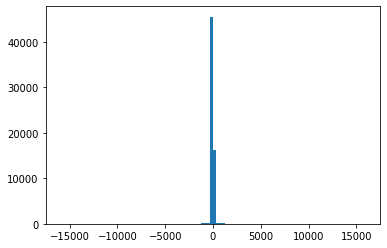

In [10]:
df = pd.read_csv(predictionDB_path,lineterminator='\n')
plt.hist(df['inc_complexity'],bins = 100)
print(max(df['inc_complexity']),min(df['inc_complexity']))
plt.show()

In [5]:
class commits_dataset(Dataset):
    def __init__(self, csv_path, embeddings_path):
        self.df = pd.read_csv(csv_path,lineterminator='\n')
        self.hashes = list(self.df['COMMIT_HASH'])
        self.embeddings_path = embeddings_path
        self.embeddings = [np.load(os.path.join(self.embeddings_path,h + '.npy')) for h in self.hashes]

    def __len__(self):
        return len(self.hashes)
    
    def __getitem__(self, index):
        h = self.hashes[index]
        target = self.df[self.df['COMMIT_HASH'] == h][['inc_complexity','inc_violations','inc_development_cost']].values.tolist()[0]
        #embedding = np.load(os.path.join(self.embeddings_path,h + '.npy'))
        embedding = self.embeddings[index]
        return torch.Tensor(embedding),torch.Tensor(target)

In [6]:
dataset = commits_dataset(predictionDB_path,embeddings_path)
print(dataset[0])

(tensor([-4.0313e-02, -6.6366e-02, -5.1735e-02,  2.4362e-02,  4.0410e-02,
        -2.7705e-02, -2.7166e-02, -4.4240e-02,  4.9759e-02,  3.5624e-02,
         6.3411e-02, -3.5625e-03, -2.2959e-02,  5.4037e-02, -5.6240e-02,
         1.9618e-02, -4.3970e-02,  3.9387e-02,  1.2992e-01,  2.6584e-02,
        -7.3223e-02,  4.6072e-02,  6.8889e-02, -2.1015e-02,  2.9225e-02,
        -4.1458e-02,  1.0940e-03, -1.9866e-02, -2.0389e-02, -2.5116e-02,
         8.5465e-02,  4.3531e-02,  5.7475e-02,  8.9396e-03,  3.1516e-02,
         8.3989e-02,  2.2156e-02,  4.1516e-03, -8.4352e-02,  2.6857e-02,
         2.2828e-02,  9.0680e-03,  9.8129e-02, -8.4019e-02, -4.7411e-02,
        -2.4661e-02,  6.2156e-02, -6.8943e-02,  1.6391e-02,  4.7138e-02,
        -4.0025e-02, -1.2615e-01,  1.1359e-02, -5.6300e-02,  1.3397e-03,
        -5.9593e-02,  3.1456e-02,  5.2028e-02, -1.0756e-02, -8.7353e-02,
         2.5061e-02,  3.7149e-03, -5.1581e-02, -8.3558e-02, -4.0749e-02,
        -1.8906e-02,  1.5661e-02,  9.2224e-03,  3.

In [7]:
bs = 32
num_workers = 2

n=len(dataset)
n_train = int(n*0.7)
n_valid = n-n_train

'''
Use first 70% of data as training and last 30% as validation
'''
train_sample, valid_sample = Subset(dataset, range(n_train)), Subset(dataset, range(n_train,n))
train_sampler = RandomSampler(train_sample)
valid_sampler = RandomSampler(valid_sample)
train_loader = DataLoader(train_sample, sampler = train_sampler, batch_size=bs, num_workers = num_workers)
valid_loader = DataLoader(valid_sample, sampler = valid_sampler, batch_size=bs, num_workers = num_workers)


In [8]:
#predictionDB["is_valid"] = np.zeros(len(predictionDB))
#for i in range(len(predictionDB["is_valid"])):
#    predictionDB["is_valid"][i] = 1 if random.random()<0.2 else 0 

In [9]:
#from fastai.text.all import *
#dls = TextDataLoaders.from_df(predictionDB, text_col='COMMIT_MESSAGE', label_col='inc_complexity', valid_col='is_valid')
#dls.show_batch(max_n=3)

In [10]:
# Multilayer perceptron
class MultilayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(384, 1024, bias=True) 
        self.lin2 = nn.Linear(1024, 120, bias=True)
        self.lin3 = nn.Linear(120, 3, bias=True)

    def forward(self, xb):
        x = xb.float()
        #x = xb.view(250, -1)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        return self.lin3(x)

In [11]:
#mlp_learner = Learner(data=data, model=MultilayerPerceptron(), loss_func=nn.CrossEntropyLoss(),metrics=accuracy)
#mlp_learner.fine_tune(20)

In [12]:
model = MultilayerPerceptron()
print(model)

MultilayerPerceptron(
  (lin1): Linear(in_features=384, out_features=1024, bias=True)
  (lin2): Linear(in_features=1024, out_features=120, bias=True)
  (lin3): Linear(in_features=120, out_features=3, bias=True)
)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

In [14]:
mean_train_losses = []
mean_valid_losses = []
valid_acc_list = []
epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(epochs):
    model.train()
    
    train_losses = []
    valid_losses = []
    for i, (embeddings, labels) in tqdm(enumerate(train_loader)):
        
        embeddings.to(device)
        labels.to(device)
        optimizer.zero_grad()
        
        outputs = model(embeddings)
        loss = loss_fn(outputs.squeeze(0),labels)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
            
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (embeddings, labels) in tqdm(enumerate(valid_loader)):
            outputs = model(embeddings)
            loss = loss_fn(outputs.squeeze(0), labels)
            
            valid_losses.append(loss.item())
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            
    mean_train_losses.append(np.mean(train_losses))
    mean_valid_losses.append(np.mean(valid_losses))
    print('epoch : {}, train loss : {:.4f}, valid loss : {:.4f}'\
         .format(epoch+1, mean_train_losses[-1], mean_valid_losses[-1]))

1377it [02:11, 10.48it/s]


epoch : 1, train loss : 526142829.8855, valid loss : 5443340899.9081


1377it [02:08, 10.75it/s]


epoch : 2, train loss : 526115404.6142, valid loss : 5443233784.8352


1377it [02:04, 11.02it/s]


epoch : 3, train loss : 526072666.5506, valid loss : 5443541563.0400


1377it [02:11, 10.50it/s]


epoch : 4, train loss : 526007670.3603, valid loss : 5443014960.4090


339it [00:32, 10.28it/s]


KeyboardInterrupt: 